# Baseline CNN Training on Tiny ImageNet

This notebook establishes a baseline CNN model for the Tiny ImageNet dataset.


In [13]:
# Import necessary libraries
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import requests
import zipfile
import shutil
from tqdm.notebook import tqdm

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cuda:0


## Download and Prepare Dataset


In [14]:
def download_and_extract_tiny_imagenet():
    """Download and extract the Tiny ImageNet dataset"""
    os.makedirs('./data', exist_ok=True)
    
    if os.path.exists('./data/tiny-imagenet-200'):
        print("Dataset already exists.")
        return
    
    url = 'http://pages.ucsd.edu/~ztu/courses/tiny-imagenet-200.zip'
    print("Downloading Tiny ImageNet dataset...")
    response = requests.get(url, stream=True)
    
    zip_path = './data/tiny-imagenet-200.zip'
    with open(zip_path, 'wb') as f:
        for chunk in tqdm(response.iter_content(chunk_size=1024*1024)):
            if chunk:
                f.write(chunk)
    
    print("Extracting Tiny ImageNet dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('./data')
    
    os.remove(zip_path)
    print("Download and extraction complete.")

# Download and extract dataset
download_and_extract_tiny_imagenet()

Dataset already exists.


In [15]:
def prepare_tiny_imagenet():
    """Prepare the Tiny ImageNet dataset for PyTorch"""
    # Define transforms
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(64, padding=4),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Paths to the data
    data_dir = './data/tiny-imagenet-200'
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    
    # Reorganize validation data if needed
    val_img_dir = os.path.join(val_dir, 'images')
    if os.path.exists(val_img_dir):
        print("Reorganizing validation data...")
        val_dict = {}
        with open(os.path.join(val_dir, 'val_annotations.txt'), 'r') as f:
            for line in f.readlines():
                parts = line.strip().split('\t')
                val_dict[parts[0]] = parts[1]
                
        # Create class directories
        for class_id in set(val_dict.values()):
            os.makedirs(os.path.join(val_dir, class_id), exist_ok=True)
            
        # Move images to their respective class directories
        for img, class_id in tqdm(val_dict.items(), desc="Organizing validation images"):
            if os.path.exists(os.path.join(val_img_dir, img)):
                shutil.move(os.path.join(val_img_dir, img), 
                         os.path.join(val_dir, class_id, img))
        
        # Remove the images directory if it's empty
        if os.path.exists(val_img_dir) and len(os.listdir(val_img_dir)) == 0:
            os.rmdir(val_img_dir)
    
    # Create datasets
    print("Creating datasets...")
    trainset = datasets.ImageFolder(train_dir, transform=transform_train)
    valset = datasets.ImageFolder(val_dir, transform=transform_val)
    
    # Create data loaders
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
    valloader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=4)
    
    class_names = trainset.classes
    
    print(f"Dataset loaded with {len(trainset)} training images and {len(valset)} validation images.")
    print(f"Number of classes: {len(class_names)}")
    
    return trainloader, valloader, class_names

# Prepare data loaders
trainloader, valloader, class_names = prepare_tiny_imagenet()

Creating datasets...
Dataset loaded with 100000 training images and 10000 validation images.
Number of classes: 200


## Define Baseline CNN Model


In [16]:
class BaselineCNN(nn.Module):
    """Baseline CNN for Tiny ImageNet classification"""
    def __init__(self, num_classes=200):
        super(BaselineCNN, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64 -> 32
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32 -> 16
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16 -> 8
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8 -> 4
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Create model
model = BaselineCNN(len(class_names))
model = model.to(device)

# Summary of model
print(model)

BaselineCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxP

## Training and Evaluation Functions


In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        running_corrects += torch.sum(preds == labels.data).item()
        processed_size += batch_size
    
    epoch_loss = running_loss / processed_size
    epoch_acc = running_corrects / processed_size
    
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion):
    """Evaluate the model"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Statistics
            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            running_corrects += torch.sum(preds == labels.data).item()
            processed_size += batch_size
    
    epoch_loss = running_loss / processed_size
    epoch_acc = running_corrects / processed_size
    
    return epoch_loss, epoch_acc

## Train Model


In [18]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Number of epochs
num_epochs = 30

# Initialize variables
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Training loop
since = time.time()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    # Train and evaluate
    train_loss, train_acc = train_one_epoch(model, trainloader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, valloader, criterion)
    
    # Update learning rate
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch results
    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'model/baseline/best_model.pth')
        print(f'New best model saved with accuracy: {best_acc:.4f}')
    
    print()

# Calculate training time
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val accuracy: {best_acc:.4f}')

# Load best model
model.load_state_dict(best_model_wts)

Epoch 1/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 4.8443 Acc: 0.0342
Val Loss: 4.3295 Acc: 0.0770
New best model saved with accuracy: 0.0770

Epoch 2/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 4.1787 Acc: 0.0973
Val Loss: 4.0573 Acc: 0.1080
New best model saved with accuracy: 0.1080

Epoch 3/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 3.8583 Acc: 0.1397
Val Loss: 3.6780 Acc: 0.1632
New best model saved with accuracy: 0.1632

Epoch 4/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 3.6177 Acc: 0.1778
Val Loss: 3.6628 Acc: 0.1764
New best model saved with accuracy: 0.1764

Epoch 5/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 3.4363 Acc: 0.2085
Val Loss: 3.3298 Acc: 0.2312
New best model saved with accuracy: 0.2312

Epoch 6/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 3.2788 Acc: 0.2355
Val Loss: 3.2116 Acc: 0.2497
New best model saved with accuracy: 0.2497

Epoch 7/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 3.1454 Acc: 0.2606
Val Loss: 3.0898 Acc: 0.2671
New best model saved with accuracy: 0.2671

Epoch 8/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 3.0277 Acc: 0.2844
Val Loss: 3.0301 Acc: 0.2852
New best model saved with accuracy: 0.2852

Epoch 9/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.9189 Acc: 0.3046
Val Loss: 2.9147 Acc: 0.3037
New best model saved with accuracy: 0.3037

Epoch 10/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.8224 Acc: 0.3231
Val Loss: 2.9043 Acc: 0.3126
New best model saved with accuracy: 0.3126

Epoch 11/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.5521 Acc: 0.3801
Val Loss: 2.4659 Acc: 0.4001
New best model saved with accuracy: 0.4001

Epoch 12/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.4901 Acc: 0.3915
Val Loss: 2.4402 Acc: 0.4085
New best model saved with accuracy: 0.4085

Epoch 13/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.4639 Acc: 0.3974
Val Loss: 2.4253 Acc: 0.4047

Epoch 14/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.4349 Acc: 0.4036
Val Loss: 2.4071 Acc: 0.4114
New best model saved with accuracy: 0.4114

Epoch 15/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.4137 Acc: 0.4092
Val Loss: 2.4016 Acc: 0.4155
New best model saved with accuracy: 0.4155

Epoch 16/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.3923 Acc: 0.4123
Val Loss: 2.3916 Acc: 0.4130

Epoch 17/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.3720 Acc: 0.4174
Val Loss: 2.3698 Acc: 0.4213
New best model saved with accuracy: 0.4213

Epoch 18/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.3473 Acc: 0.4233
Val Loss: 2.3760 Acc: 0.4224
New best model saved with accuracy: 0.4224

Epoch 19/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.3325 Acc: 0.4269
Val Loss: 2.3571 Acc: 0.4202

Epoch 20/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.3112 Acc: 0.4294
Val Loss: 2.3456 Acc: 0.4242
New best model saved with accuracy: 0.4242

Epoch 21/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.2564 Acc: 0.4442
Val Loss: 2.3028 Acc: 0.4314
New best model saved with accuracy: 0.4314

Epoch 22/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.2453 Acc: 0.4461
Val Loss: 2.2974 Acc: 0.4351
New best model saved with accuracy: 0.4351

Epoch 23/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.2421 Acc: 0.4450
Val Loss: 2.2964 Acc: 0.4374
New best model saved with accuracy: 0.4374

Epoch 24/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.2372 Acc: 0.4458
Val Loss: 2.2929 Acc: 0.4359

Epoch 25/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.2342 Acc: 0.4470
Val Loss: 2.2898 Acc: 0.4377
New best model saved with accuracy: 0.4377

Epoch 26/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.2305 Acc: 0.4482
Val Loss: 2.2912 Acc: 0.4380
New best model saved with accuracy: 0.4380

Epoch 27/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.2291 Acc: 0.4481
Val Loss: 2.2898 Acc: 0.4385
New best model saved with accuracy: 0.4385

Epoch 28/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.2232 Acc: 0.4495
Val Loss: 2.2892 Acc: 0.4389
New best model saved with accuracy: 0.4389

Epoch 29/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.2252 Acc: 0.4500
Val Loss: 2.2862 Acc: 0.4391
New best model saved with accuracy: 0.4391

Epoch 30/30
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 2.2184 Acc: 0.4494
Val Loss: 2.2875 Acc: 0.4375

Training complete in 55m 3s
Best val accuracy: 0.4391


<All keys matched successfully>

## Visualize Results


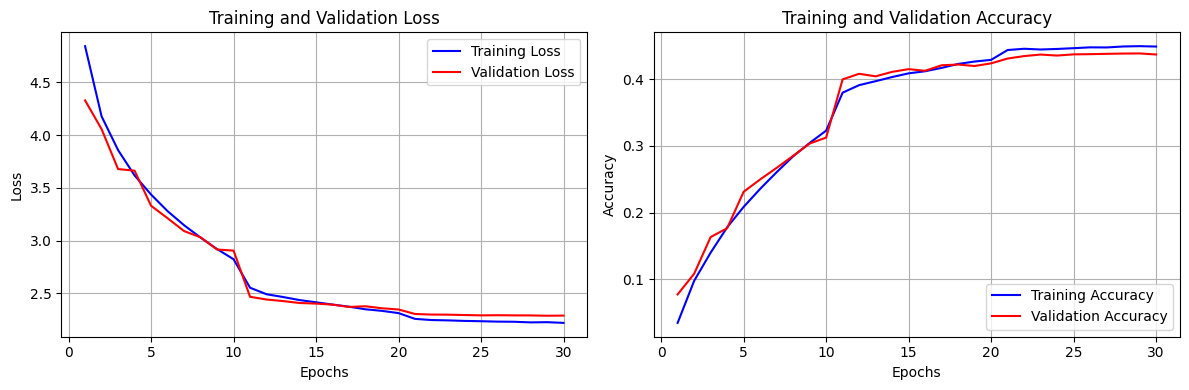

In [23]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), history['train_loss'], 'b-', label='Training Loss')
plt.plot(range(1, num_epochs+1), history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), history['train_acc'], 'b-', label='Training Accuracy')
plt.plot(range(1, num_epochs+1), history['val_acc'], 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves_baseline.png')
plt.show()

## Class-wise Performance


In [20]:
def get_class_accuracies(model, dataloader, class_names):
    """Calculate per-class accuracies"""
    model.eval()
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Calculating class accuracies"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            correct = (preds == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1
    
    # Calculate accuracies
    class_accuracies = {}
    for i in range(len(class_names)):
        if class_total[i] > 0:
            class_accuracies[class_names[i]] = class_correct[i] / class_total[i]
    
    return class_accuracies

# Get class accuracies
class_accuracies = get_class_accuracies(model, valloader, class_names)

# Print overall accuracy
overall_acc = sum(class_accuracies.values()) / len(class_accuracies)
print(f"Overall accuracy: {overall_acc:.4f}")

# Find best and worst classes
best_classes = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)[:5]
worst_classes = sorted(class_accuracies.items(), key=lambda x: x[1])[:5]

print("\nBest performing classes:")
for cls, acc in best_classes:
    print(f"{cls}: {acc:.4f}")

print("\nWorst performing classes:")
for cls, acc in worst_classes:
    print(f"{cls}: {acc:.4f}")

Calculating class accuracies:   0%|          | 0/79 [00:00<?, ?it/s]

Overall accuracy: 0.4391

Best performing classes:
n02279972: 0.8200
n04118538: 0.8200
n02074367: 0.8000
n04146614: 0.8000
n01443537: 0.7800

Worst performing classes:
n03970156: 0.0000
n02999410: 0.0600
n04597913: 0.0600
n04067472: 0.0800
n02909870: 0.1000


## Save and Load Model


In [21]:
# Save the final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': best_acc,
    'history': history
}, 'model/baseline/final_model.pth')

print("Model saved to 'final_model.pth'")

Model saved to 'final_model.pth'


In [22]:
# Example of how to load the model
def load_model(model_path, model_class, num_classes):
    # Initialize model
    model = model_class(num_classes=num_classes)
    
    # Load checkpoint
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    
    return model, checkpoint

# Example usage (commented out to avoid execution)
# loaded_model, checkpoint = load_model('final_model.pth', BaselineCNN, len(class_names))
# print(f"Loaded model with validation accuracy: {checkpoint['val_acc']:.4f}")

## Conclusion

This notebook has established a baseline CNN model for the Tiny ImageNet dataset. You can use this as a foundation for more advanced architectures and experiments in your final project.

### Next Steps:

1. Try different architectures (VGG, ResNet, etc.)
2. Experiment with various hyperparameters (learning rate, batch size, etc.)
3. Implement attention mechanisms
4. Explore different optimization techniques
5. Use more advanced regularization methods
6. Test various data augmentation strategies
